# Step 4: Applying the MaxEnt Model 🚀

https://pypi.org/project/elapid/0.1.0/

https://earth-chris.github.io/elapid/
https://earth-chris.github.io/elapid/sdm/maxent/

https://biodiversityinformatics.amnh.org/open_source/maxent/

“MaxEnt” usually means a maximum-entropy classifier (a.k.a. multinomial logistic regression).

#### 📚 Required Libraries
To carry out this process, you'll need the following libraries:
- **`pandas`**: For reading, manipulating, and analyzing the data. 
- **`elapid`**: For the MaxEnt model.
- **`sklearn`**: For the MaxEnt model.
- **`geopandas`**: 
- **`shapely`**: To convert the polygones into real `POLYGONs`

### 🛠️ Steps:
1. **Train the Model**: 
2. **Apply the Model and Plot the results**: 
3. **Comment the results - What can be improved ?**: 





_____



In [1]:
import elapid
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

### 🏋🏼 Train the Model

In [2]:
# Load the nput data
df_inputs_variables = pd.read_csv("data/03_inputs_environmental_variables.csv")
df_inputs_variables.columns

Index(['geometry', 'chl', 'no3', 'ph', 'po4', 'bottomT', 'siconc', 'sob',
       'thetao', 'uo', 'vo', 'VTM01_SW2', 'VSDX', 'presence'],
      dtype='object')

In [3]:
# Create the ndarray of environmental covariates of shape (n_samples, n_covariates)
predictor_cols = ['chl', 'no3', 'ph', 'po4', 'siconc', 'bottomT', 'sob', 'thetao', 'uo', 'vo', 'VTM01_SW2', 'VSDX']
X = df_inputs_variables[predictor_cols].values.astype(float)
# Create the ndarray or series of species presence/background labels (rows labeled 1 or 0)
y = df_inputs_variables["presence"].values.astype(int)

In [4]:
# Train / test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

In [5]:
# Instantiate a MaxEnt model
model = elapid.MaxentModel(
    feature_types=["linear", "quadratic", "hinge"],   # common MaxEnt defaults
    beta_multiplier=1.0,    # ↑ = more regularisation, ↓ = looser fit
    clamp=True,             # prevents crazy extrapolation outside env. range
    n_cpus=4                # parallel cores; set to 1 if you prefer serial
)

In [6]:
# Fit the model
model.fit(X_tr, y_tr)

MaxentModel(beta_multiplier=1.0, feature_types=['linear', 'quadratic', 'hinge'],
            n_cpus=4)

### 🚀 Apply the Model and Plot the results

In [7]:
# Probabilities on held-out test fold
proba_test = model.predict_proba(X_te)[:, 1]
print("ROC AUC :", roc_auc_score(y_te, proba_test))
print("PR AUC  :", average_precision_score(y_te, proba_test))

ROC AUC : 0.9853586380540535
PR AUC  : 0.752198050605439


In [8]:
# Full-data predictions to append back to your dataframe
df_inputs_variables["suitability_logistic"] = model.predict_proba(X)[:, 1]

df_inputs_variables.to_csv("zosteraceae_with_suitability.csv", index=False)

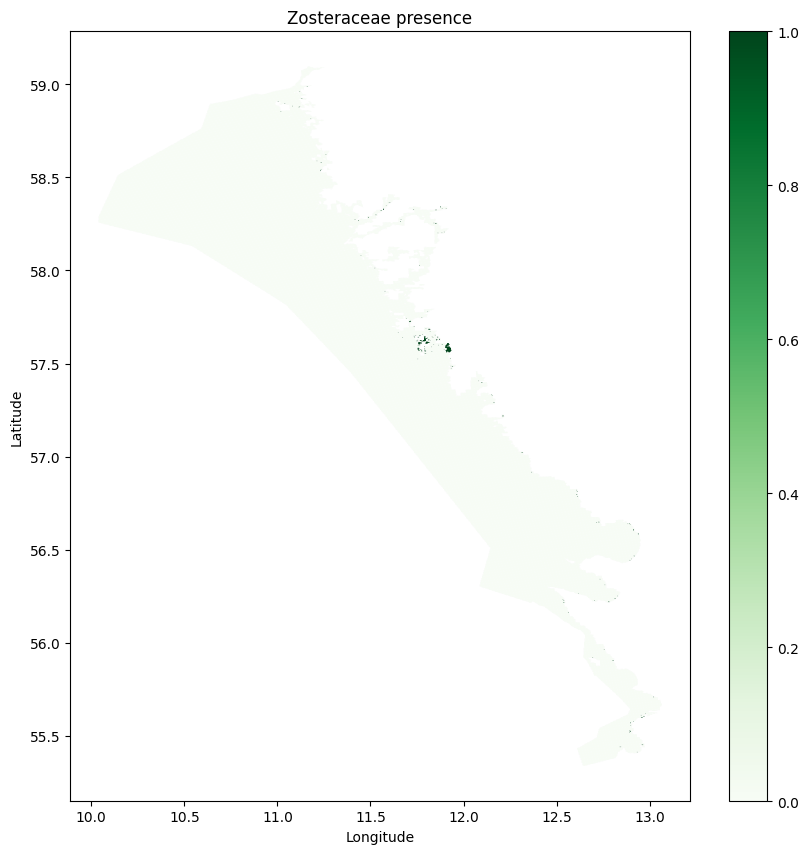

In [10]:
# Plot the result with the geometry
fig, ax = plt.subplots(figsize=(10, 10))
# Convert the DataFrame to a GeoDataFrame for plotting
df_inputs_variables["geometry"] = df_inputs_variables["geometry"].apply(wkt.loads)
gdf_plot = gpd.GeoDataFrame(df_inputs_variables, geometry="geometry", crs="EPSG:3006")
gdf_plot.plot(column="presence", ax=ax, legend=True, cmap="Greens")
plt.title("Zosteraceae presence")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

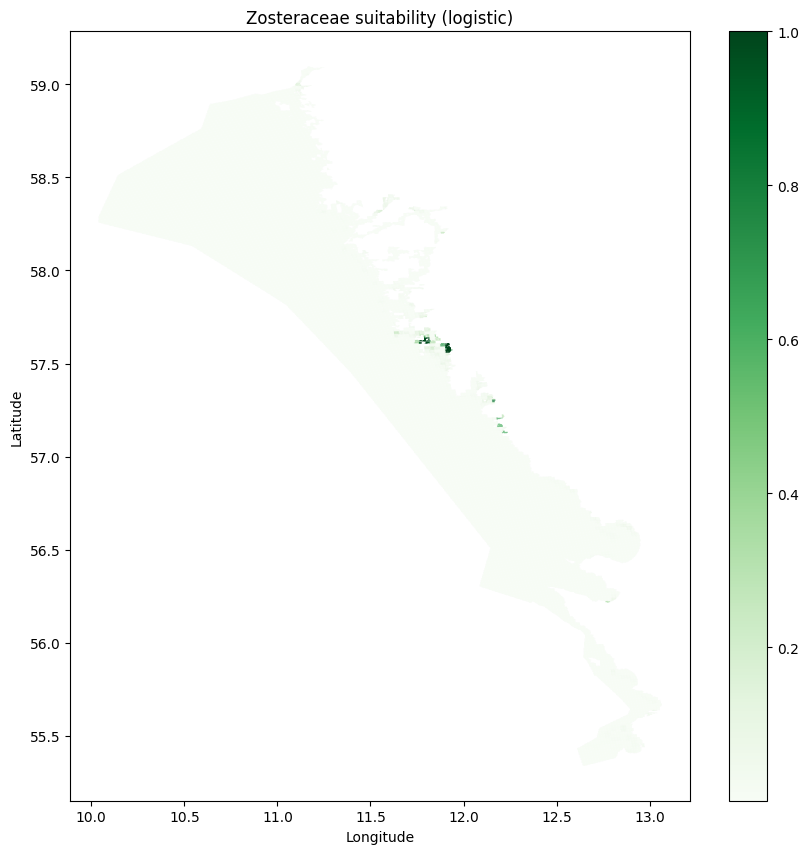

In [11]:
# Plot the result with the geometry
fig, ax = plt.subplots(figsize=(10, 10))
# Convert the DataFrame to a GeoDataFrame for plotting
# df_inputs_variables["geometry"] = df_inputs_variables["geometry"].apply(wkt.loads)
gdf_plot = gpd.GeoDataFrame(df_inputs_variables, geometry="geometry", crs="EPSG:3006")
gdf_plot.plot(column="suitability_logistic", ax=ax, legend=True, cmap="Greens")
plt.title("Zosteraceae suitability (logistic)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [12]:
# Calculate the total area of the species presence (number of cells * 250 m²)
total_area = gdf_plot[gdf_plot["presence"] == 1].shape[0] * 250
print(f"Total area of Zosteraceae presence: {total_area} square meters")

# Calculate the total area of the species suitability (number of cells * 250 m²)
total_suitability_area = gdf_plot[gdf_plot["suitability_logistic"] > 0.5].shape[0] * 250
print(f"Total area of Zosteraceae suitability: {total_suitability_area} square meters")


Total area of Zosteraceae presence: 245000 square meters
Total area of Zosteraceae suitability: 251000 square meters


### 💬 Comment